# Tagup data science challenge

ExampleCo, Inc has a problem: maintenance on their widgets is expensive. They have contracted with Tagup to help them implement predictive maintenance. They want us to provide a model that will allow them to prioritize maintenance for those units most likely to fail, and in particular to gain some warning---even just a few hours!---before a unit does fail.

They collect two kinds of data for each unit. First, they have a remote monitoring system for the motors in each unit, which collects information about the motor (rotation speed, voltage, current) as well as two temperature probes (one on the motor and one at the inlet). Unfortunately, this system is antiquated and prone to communication errors, which manifest as nonsense measurements. Second, they have a rule-based alarming system, which can emit either warnings or errors; the system is known to be noisy, but it's the best they've got. 

They have given us just over 100MB of historical remote monitoring data from twenty of their units that failed in the field. The shortest-lived units failed after a few days; the longest-lived units failed after several years. Typical lifetimes are on the order of a year. This data is available in .csv files under `data/train` in this repository. In addition, they have provided us with operating data from their thirty active units for the past month; this data is available under `data/test` in this repository.

You have two main objectives. First, **tell us as much as you can about the process that generated the data**. Does it show meaningful clustering? Do the observations appear independent? How accurately can we forecast future observations, and how long a window do we need to make an accurate forecast? Feel free to propose multiple models, but be sure to discuss the ways each is useful and the ways each is not useful. Second, **predict which of the thirty active units are most likely to fail**. The data from these units are in `data/test`. Be sure to quantify these predictions, and especially your certainty.

A few notes to help:
1. A good place to start is by addressing the noise due to comm errors. 
2. There is a signal in the data that you can identify and exploit to predict failure.
3. If you can't find the signal in the noise, don't despair! We're much more interested in what you try and how you try it than in how successful you are at helping a fictional company with their fictional problems.
4. Feel free to use any libraries you like, or even other programming languages. Your final results should be presented in this notebook, however.
5. There are no constraints on the models or algorithms you can bring to bear. Some ideas include: unsupervised clustering algorithms such as k-means; hidden Markov models; forecasting models like ARMA; neural networks; survival models built using features extracted from the data; etc.
6. Don't feel compelled to use all the data if you're not sure how. Feel free to focus on data from a single unit if that makes it easier to get started.
7. Be sure to clearly articulate what you did, why you did it, and how the results should be interpreted. In particular you should be aware of the limitations of whatever approach or approaches you take.
8. Don't hesitate to reach out with any questions.

,rpm,motor_voltage,motor_current,motor_temp,inlet_temp
count,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04,9.171500e+04
mean,-8.111152e+46,-4.431337e+60,-1.387827e+56,-6.640742e+69,-1.937422e+48
std,2.456380e+49,1.903274e+63,4.202968e+58,2.011115e+72,5.867349e+50
min,-7.439020e+51,-5.565298e+65,-1.272847e+61,-6.090557e+74,-1.776896e+53
25%,1.017725e+03,2.311319e+02,3.239347e+01,1.179731e+02,6.489677e+01
50%,1.066347e+03,2.667104e+02,3.944687e+01,1.564521e+02,7.799157e+01
75%,1.106721e+03,2.993994e+02,4.607173e+01,1.978223e+02,9.086132e+01
max,7.978110e+44,1.500194e+65,1.555360e+55,3.117856e+55,1.710299e+40


,message
count,305
unique,2
top,warning
freq,304


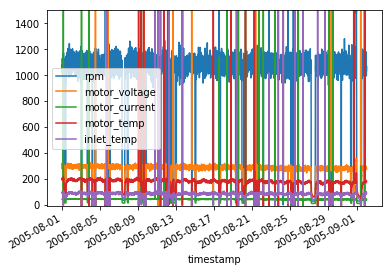

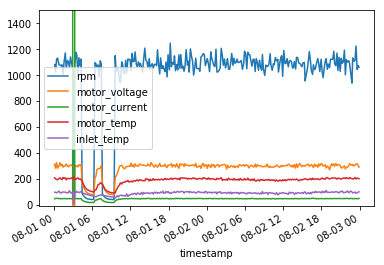

In [1]:
# To help you get started...
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

def load_rms(filename):
    return pd.read_csv(filename, index_col="timestamp", parse_dates=True)
def load_alarms(filename):
    return pd.read_csv(filename, header=None, names=["timestamp", "message"], index_col="timestamp", parse_dates=True)

rms = load_rms('data/train/unit0000_rms.csv')
alarms = load_alarms('data/train/unit0000_alarms.csv')
rms.loc["2005-08-01":"2005-09-01"].plot(ylim=(-10, 1500))
rms.loc["2005-08-01":"2005-08-02"].plot(ylim=(-10, 1500))

display(rms.describe())
display(alarms.describe())

# Dataset Info

In [2]:
rms.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 91715 entries, 2003-12-13 19:56:43.777979848 to 2005-09-10 17:36:47.236452969
Data columns (total 5 columns):
rpm              91715 non-null float64
motor_voltage    91715 non-null float64
motor_current    91715 non-null float64
motor_temp       91715 non-null float64
inlet_temp       91715 non-null float64
dtypes: float64(5)
memory usage: 6.7 MB


In [3]:
alarms.head()

,message
timestamp,
2003-12-15 19:18:56.526325850,warning
2003-12-15 23:29:11.344610850,warning
2003-12-17 16:26:26.782823329,warning
2003-12-18 02:21:51.445540122,warning
2004-01-04 17:16:12.501831699,warning


# De-noising

Looking at the second plot, where the data between 8/1/2005 and 8/2/2005 shows one odd anomaly and two clear failures, we can try to filter out the anomalies while keeping the failures. It's safe to assume the failures last longer than the strange communication anomalies. 

A median filter would work great, as it uses purely the data given to us without interpolation. Note that the failure times would shift slightly, but I don't expect this to be a big problem. 

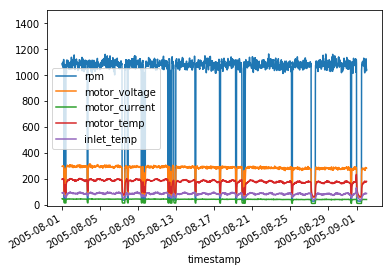

In [4]:
from scipy.signal import medfilt

def denoise_signal(df, kernel_size=3):
    return df.apply(lambda x: medfilt(x, kernel_size=kernel_size))

rms = denoise_signal(rms, 7)

rms.loc["2005-08-01":"2005-09-01"].plot(ylim=(-10, 1500))

# What is failure?

It's probably safe to assume failure is defined as motor RPM below a certain value. It looks like below 400 RPM is a reasonable value. 

In [5]:
rms['fail'] = rms['rpm'] < 400

How does this correlate to the alarms?

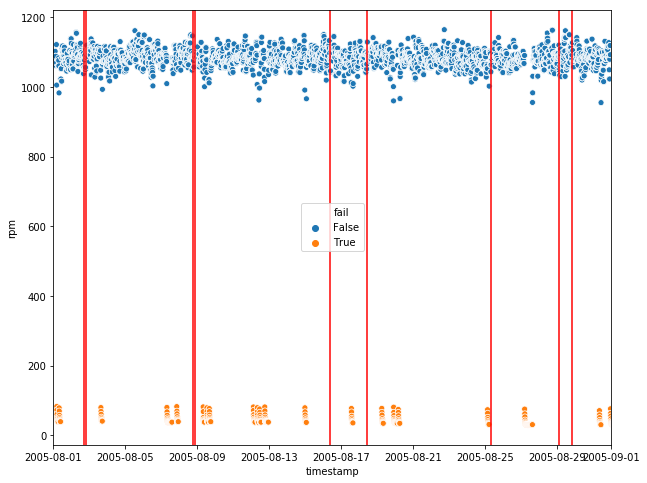

In [6]:
import seaborn as sns
window = rms.loc["2005-08-01":"2005-09-01"]
alarm_window = alarms.loc["2005-08-01":"2005-09-01"]
plt.figure(figsize=(10,8))
sns.scatterplot(x=window.index, y='rpm', hue='fail', data=window)
for i in alarm_window.loc["2005-08-01":"2005-09-01"].index:
    plt.axvline(x=i, color='r')
    
plt.xlim(("2005-08-01", "2005-09-01"))
plt.show()

Red vertical lines are when the alarms were posted. There are some instances where the alarm is indicative; after an alarm, a failure generally follows after a short period of time (a few hours?). However, there are multiple failure points that didn't come after an alarm. Let's save a series of dates in which the motor failed. 

In [7]:
failure_dates = rms[rms['fail'] == True].index.to_series()

# Temperature

It's clear that there's an oscillatory pattern in the motor temperature and inlet temperature signals. How do these look?

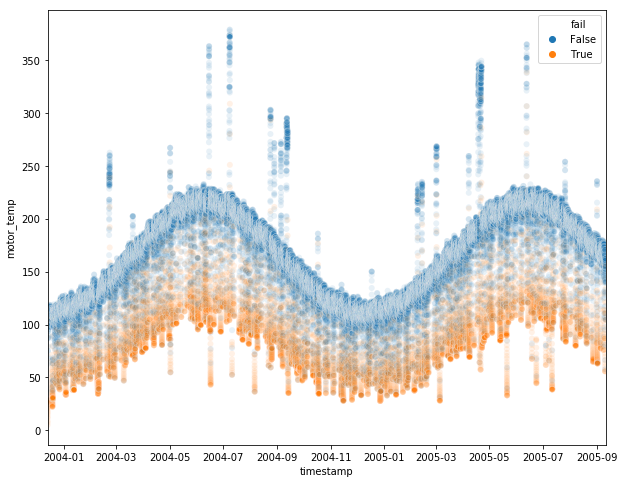

In [8]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=rms.index, y='motor_temp', hue='fail', data=rms, alpha=0.1)
plt.xlim((rms.index[0], rms.index[-1]))
plt.show()

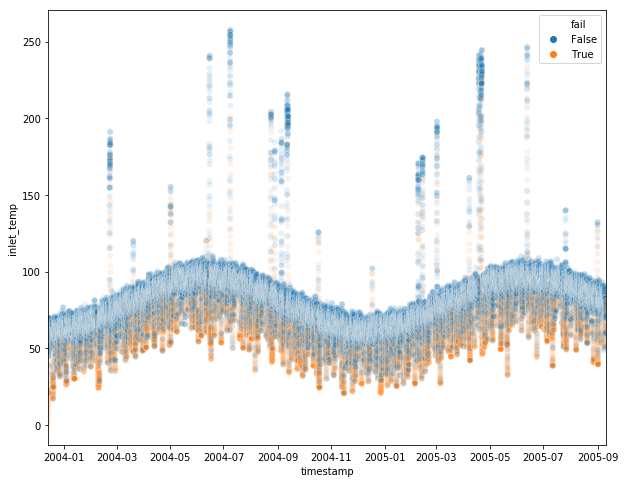

In [9]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=rms.index, y='inlet_temp', hue='fail', data=rms, alpha=0.1)
plt.xlim((rms.index[0], rms.index[-1]))
plt.show()

Temperatures during failure are generally lower than when the unit is not failing. That's pretty understandable, but it appears the spikes in temperatures occur in both the inlet temperature and the motor temperature. In both cases, there's also a long-term oscillatory trend in temperature, and it's warmer in the summer and cooler in the winter. I'm a big fan of dimensionless numbers; let's take a ratio of the two and see what that looks like. 

## Temperature Ratio

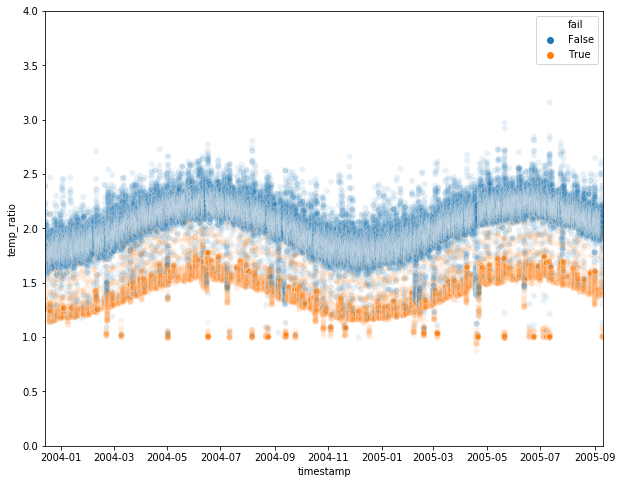

In [10]:
rms['temp_ratio'] = rms['motor_temp'] / rms['inlet_temp']
plt.figure(figsize=(10,8))
sns.scatterplot(x=rms.index, y='temp_ratio', hue='fail', data=rms, alpha=0.1)
plt.ylim((0, 4))
plt.xlim((rms.index[0], rms.index[-1]))
plt.show()

Temperature ratio during failures are generally lower. There are a few points where the temperature of the inlet and the motor are the same (ratio of 1.0). These points are generally indicated as "fail", which makes some intuitive sense. 

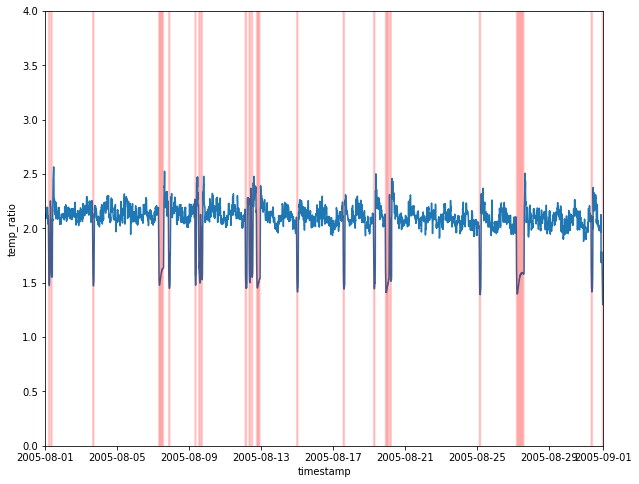

In [11]:
plt.figure(figsize=(10,8))
plt.plot(rms.index, rms['temp_ratio'])
for i in failure_dates[(failure_dates > "2005-08-01") & (failure_dates < "2005-09-01")]:
    plt.axvline(x=i, color='r', alpha=0.03)
plt.xlabel('timestamp')
plt.ylabel('temp_ratio')
plt.xlim(("2005-08-01", "2005-09-01"))
plt.ylim((0, 4))
plt.show()

Pink, vertical lines from here on out are when the motor RPM drops significantly (when the motor fails). The temperature ratio jumps up after every failure. Not helpful in predicting when the motor fails, but still interesting. There is a strong dip every time the motor fails though. 

# Ohm's Law

Ohm's law tells us $V=IR$, where $V$ is voltage, $I$ is current, and $R$ is resistance. First, let's see how the voltage and current look upon failure, then analyze resistance over the course of this unit's lifetime. 

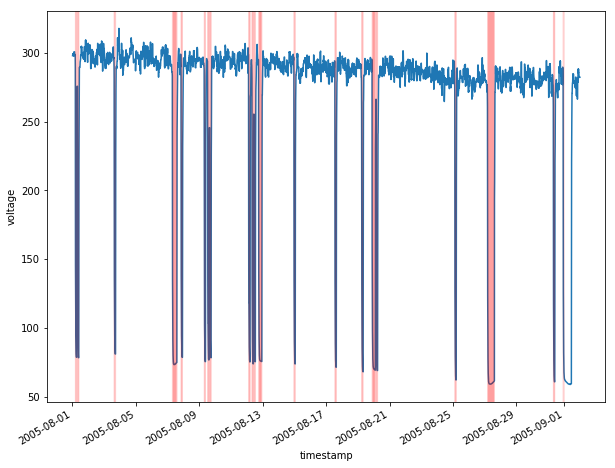

In [12]:
plt.figure(figsize=(10,8))
rms['motor_voltage'].loc["2005-08-01":"2005-09-01"].plot()
for i in failure_dates[(failure_dates > "2005-08-01") & (failure_dates < "2005-09-01")]:
    plt.axvline(x=i, color='r', alpha=0.03)
plt.xlabel('timestamp')
plt.ylabel('voltage')
plt.show()

As expected, there are huge drops in voltage when the motor fails, but not to 0 voltage. More interestingly, there's a large drop on 2005-09-01, but the entire segment is not highlighted, indicating that despite the large voltage drop, there was no failure there. 

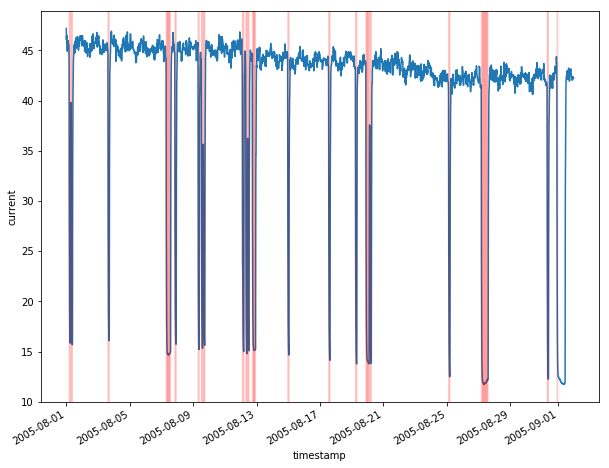

In [13]:
plt.figure(figsize=(10,8))
rms['motor_current'].loc["2005-08-01":"2005-09-01"].plot()
for i in failure_dates[(failure_dates > "2005-08-01") & (failure_dates < "2005-09-01")]:
    plt.axvline(x=i, color='r', alpha=0.03)
plt.xlabel('timestamp')
plt.ylabel('current')
plt.show()

Much the same as the voltage plot. Large drops in current when the unit fails, but not to 0 current. Same anomaly on 2005-09-01. 

In [14]:
rms['motor_resistance'] = rms['motor_voltage'] / rms['motor_current']

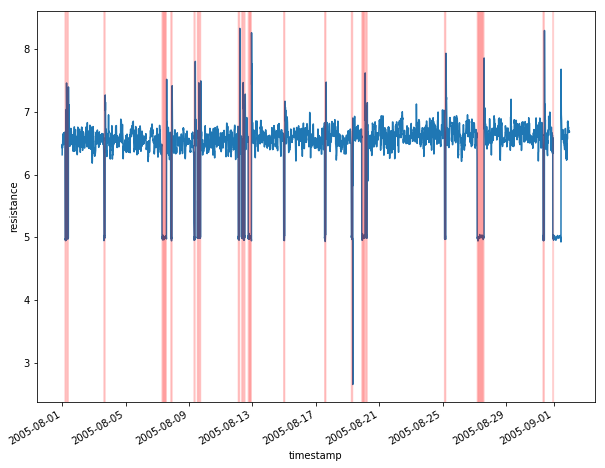

In [15]:
plt.figure(figsize=(10,8))
rms['motor_resistance'].loc["2005-08-01":"2005-09-01"].plot()
for i in failure_dates[(failure_dates > "2005-08-01") & (failure_dates < "2005-09-01")]:
    plt.axvline(x=i, color='r', alpha=0.03)
plt.xlabel('timestamp')
plt.ylabel('resistance')
plt.show()

Large spikes in resistance during failures. 

# Power Output

Defined as $P=VI$. I don't really expect this to look that different from the other plots, but you never know until you try.

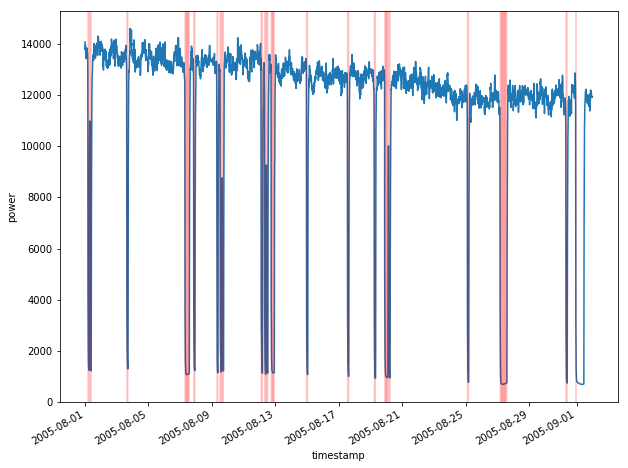

In [16]:
rms['electrical_power'] = rms['motor_voltage'] * rms['motor_current']

plt.figure(figsize=(10,8))
rms['electrical_power'].loc["2005-08-01":"2005-09-01"].plot()
for i in failure_dates[(failure_dates > "2005-08-01") & (failure_dates < "2005-09-01")]:
    plt.axvline(x=i, color='r', alpha=0.03)
plt.xlabel('timestamp')
plt.ylabel('power')
plt.show()

# Clustering

Can we find groups of related data?

## PCA

This isn't a clustering method of course, but it's easier to visualize on a 2D surface. 

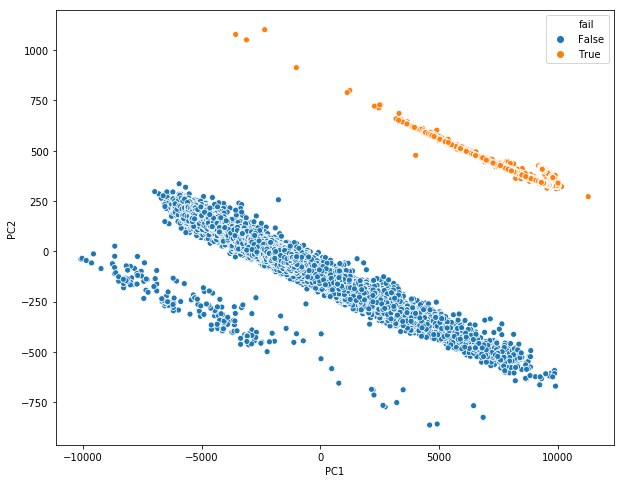

In [17]:
from sklearn.decomposition import PCA

p = PCA(n_components=2)

reduced = p.fit_transform(rms.drop(columns=['fail']))

plt.figure(figsize=(10,8))
sns.scatterplot(x=reduced.T[0], y=reduced.T[1], hue=rms['fail'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Clearly, there are three clusters, one of which includes all of the failure points. 

In [18]:
print('PC1 explains %.1f percent and PC2 explains %.1f percent of the variance in the data.' % (p.explained_variance_ratio_[0]*100, p.explained_variance_ratio_[1]*100))

PC1 explains 99.8 percent and PC2 explains 0.2 percent of the variance in the data.


## Clustering the Principal Components

Let's see if we can cluster the three groups together. Each cluster looks like nice and linearly separable, but anisotropic. K-means clustering benefits well from "spherical"-appearing clusters, where the variance is about the same in any given direction. Furthermore, k-means is not robust to outliers, and the one outlier I found is definitely going to mess with the clustering. I tried k-means just to verify it wouldn't work, and it didn't. 

/mnt/c/Users/Eric Taw/data-science-challenge/.venv/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:971: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


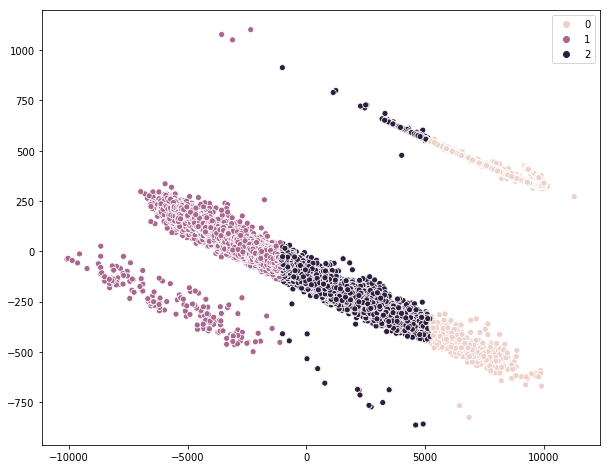

In [19]:
from sklearn.cluster import KMeans

plt.figure(figsize=(10,8))
cluster = KMeans(
    n_clusters=3,
    init=np.array([
        [1000,-100],
        [-5000,250],
        [-5000,-250]
    ])
)
cluster.fit(reduced)

sns.scatterplot(x=reduced.T[0], y=reduced.T[1], hue=cluster.labels_)

Gaussian mixture models are known to work well with anisotropic data, as shown by [the comparison on sklearn's site.](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html) It assumes that the clusters are normally distributed. DBSCAN is a nice, very flexible alternative, but we already know how many clusters there should be. 

I tried a couple clustering methods here, spending a lot of time trying to get three clean clusters. Strangely, I get different results when I run the same cell twice on occasion, despite defining the initial means. Instead, I decided to find two clusters, which should hopefully separate normal running conditions from anomalous data points. 

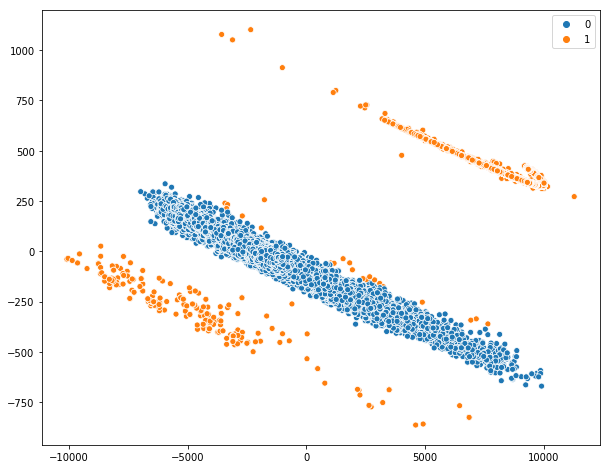

In [20]:
from sklearn.mixture import GaussianMixture

plt.figure(figsize=(10,8))
cluster = GaussianMixture(
    n_components=2,
#     means_init=[
#         [1000,-100],
#         [-5000,-250],
#         [5000,600]
#     ],
    tol=1e-12,
    max_iter=500,
    random_state=42
)
labels = cluster.fit_predict(reduced)

sns.scatterplot(x=reduced.T[0], y=reduced.T[1], hue=labels)

Beautiful! The Gaussian mixture model accurately separates normal running conditions from anomalous ones, as can be seen below.

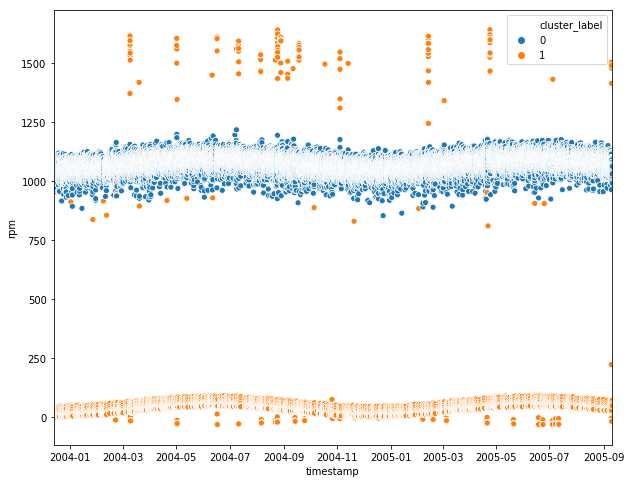

In [21]:
rms['cluster_label'] = labels

plt.figure(figsize=(10,8))
sns.scatterplot(x=rms.index, y='rpm', hue='cluster_label', data=rms)
plt.xlim(("2003-12-13", "2005-09-10"))
plt.show()

Judging by the RPM plot, PCA was able to discriminate times when the motor failed, was under normal operation, and was running abnormally quickly. High RPM data points could be an anomaly and a result of communication errors, but one would need domain knowledge to know if this is the case. 

# Clustering on Normal Conditions

Now that we have a cluster for the normal condition, we can do a similar analysis just on that data. Let's remove the RPM column, as that is essentially what we're trying to forecast (whether RPM is low, indicating failure, or normal). 

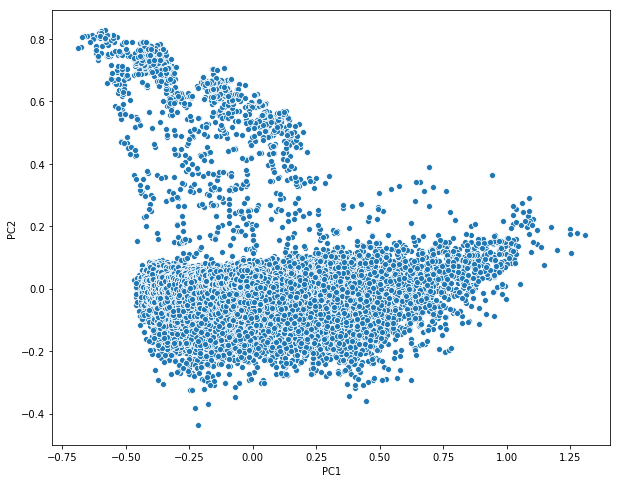

In [22]:
from sklearn.preprocessing import MinMaxScaler

normal = rms[rms['cluster_label'] == 0].drop(columns=['fail', 'cluster_label', 'rpm'])
scaler = MinMaxScaler()
X = scaler.fit_transform(normal)
pnorm = PCA(n_components=2)
X = pnorm.fit_transform(X)

plt.figure(figsize=(10,8))
sns.scatterplot(x=X.T[0], y=X.T[1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

<Figure size 720x576 with 0 Axes>

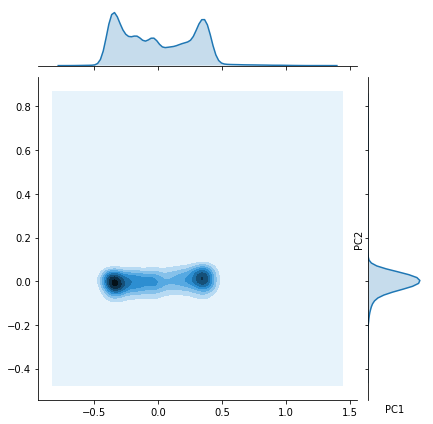

In [35]:
plt.figure(figsize=(10,8))
sns.jointplot(x=X.T[0], y=X.T[1], kind='kde')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [23]:
print('PC1 explains %.1f percent and PC2 explains %.1f percent of the variance in the data.' % (pnorm.explained_variance_ratio_[0]*100, pnorm.explained_variance_ratio_[1]*100))

PC1 explains 90.5 percent and PC2 explains 8.2 percent of the variance in the data.


It's clear the distribution is bimodal with respect to PC1 and unimodal with respect to PC2. We can extract these two modes and outliers using DBSCAN. 

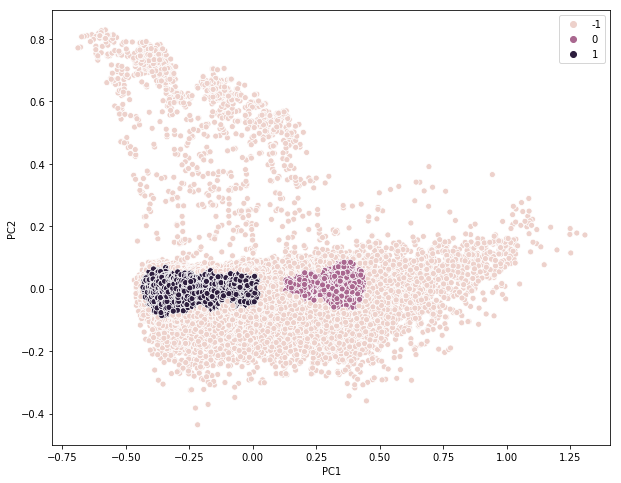

In [95]:
from sklearn.cluster import DBSCAN

clusternorm = DBSCAN(eps=0.02, min_samples=700, leaf_size=20)

labels = clusternorm.fit_predict(X)

plt.figure(figsize=(10,8))
sns.scatterplot(x=X.T[0], y=X.T[1], hue=labels)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

(732128.0186836596, 732137.9341175319)

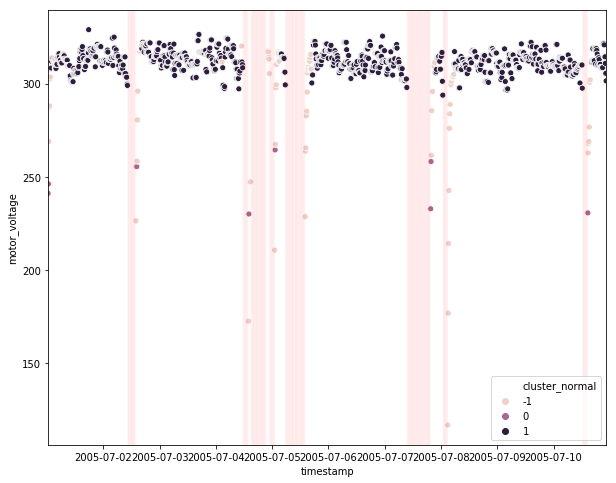

In [110]:
normal['cluster_normal'] = labels

window = normal.loc["2005-07-01":"2005-07-10"]

plt.figure(figsize=(10,8))
sns.scatterplot(x=window.index, y='motor_voltage', hue='cluster_normal', data=window)
# clust1 = window[window['cluster_normal'] == 0]
# clust2 = window[window['cluster_normal'] == 1]
# plt.scatter(clust1.index, clust1['electrical_power'], color='b')
# plt.scatter(clust2.index, clust2['electrical_power'], color='r')

for i in failure_dates.loc["2005-07-01":"2005-07-10"]:
    plt.axvline(x=i, color='r', alpha=0.02)

plt.xlim((window.index[0], window.index[-1]))
# plt.xlim(("2005-08-01", "2005-09-01"))

It appears the clustering captured outliers, especially points where the motor was starting back up. It's hard to see, but there are points categorized as `-1` and `0` among the black points categorized as `1`. 

In [111]:
rms = rms.merge(normal['cluster_normal'].to_frame(), how='left', left_index=True, right_index=True)

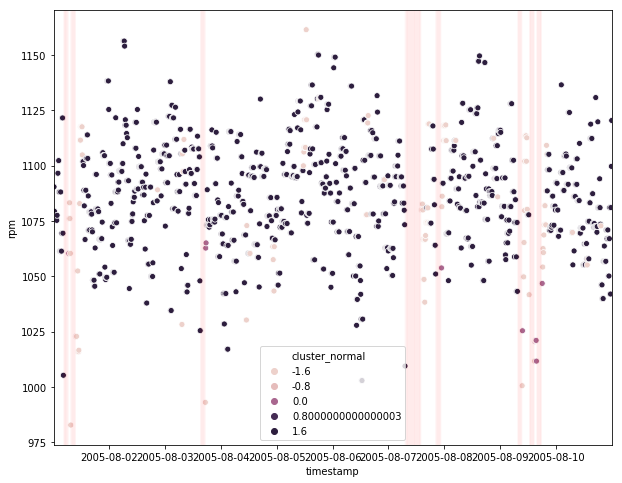

In [118]:
window = rms[rms['cluster_normal'] != np.nan].loc["2005-08-01":"2005-08-10"]
plt.figure(figsize=(10,8))
sns.scatterplot(x=window.index, y='rpm', hue='cluster_normal', data=window)
for i in failure_dates.loc["2005-08-01":"2005-08-10"]:
    plt.axvline(x=i, color='r', alpha=0.02)
plt.xlim((window.index[0], window.index[-1]))
plt.show()

Above is a plot of normal running conditions of motor RPM with the times of failure highlighted with pink vertical lines. The magenta points are hard to see, so I'll make another plot that shows just those to see if there's a pattern. 

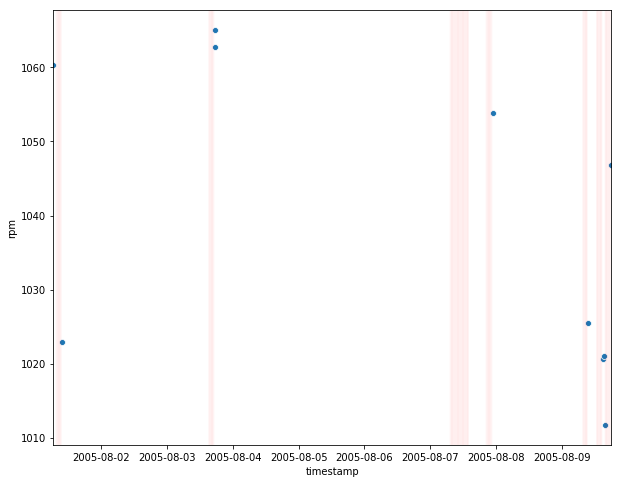

In [119]:
window = rms[rms['cluster_normal'] == 0].loc["2005-08-01":"2005-08-10"]
plt.figure(figsize=(10,8))
sns.scatterplot(x=window.index, y='rpm', data=window)
for i in failure_dates.loc["2005-08-01":"2005-08-10"]:
    plt.axvline(x=i, color='r', alpha=0.02)
plt.xlim((window.index[0], window.index[-1]))
plt.show()

As far as I can tell, the magenta points only occur just after a failure. Again, if we're trying to forecast a failure, this isn't helpful. 

# Modelling

## ARIMA